# **Libraries & Constants**

In [ ]:
# download qpth package and fix the bug in setup.py then install it
!wget https://github.com/amirezzati/Meta-Learning-for-Human-Sperm-Abnormality-Detection/raw/main/Requirements/qpth-0.0.15.tar.gz
!tar -xzvf qpth-0.0.15.tar.gz
!python qpth-0.0.15/setup.py install

In [ ]:
!pip install learn2learn

In [3]:
from tqdm import tqdm
import random

import learn2learn as l2l
import torch
import torchvision
from torch import nn, optim
from torch.optim import Optimizer, Adam
from torch.utils.data import DataLoader, Dataset, Sampler
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from torch.utils.data import random_split
from torchvision.io import read_image
from torchvision import transforms as t
from torchvision.transforms import functional as F

# cross-validaion and evaluation tools
from sklearn.metrics import classification_report
from sklearn import metrics

import cv2
import pandas as pd
import tensorflow as tf
import numpy as np
import PIL
from matplotlib import pyplot as plt
import os
from copy import deepcopy
from google.colab import drive

from typing import Callable, Union
from collections import OrderedDict

from tqdm import trange
import time

In [ ]:
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/AI Projects/Meta-learning vision project/mhsma-dataset sperm images/mhsma/"
# data_path = "/content/drive/MyDrive/AI Projects/mhsma-dataset/mhsma/"

# **Preprocessing**

In [5]:
class DatasetPair(Dataset):
  def __init__(self, x, y, transform=None, target_transform=None):
    self.img_labels = y
    self.imgs = x
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = self.imgs[idx]
    label = self.img_labels[idx]
    # if self.transform:
    #     image = self.transform(image)
    # if self.target_transform:
    #     label = self.target_transform(label)
    return image, label

In [6]:
# import dataset from path
threeChannelImg = lambda x: np.stack((x, x, x), axis=0)

def constructDataset(data_shape=64, target_type='head', channel_size=3):
  # --------- Load datasets -----------
  x_train = np.load(data_path + 'x_'+str(data_shape)+'_train.npy')
  x_dev = np.load(data_path + 'x_'+str(data_shape)+'_valid.npy')
  x_test = np.load(data_path + 'x_'+str(data_shape)+'_test.npy')

  if target_type == 'acrosome':
    y_train = np.load(data_path + 'y_acrosome_train.npy')
    y_dev = np.load(data_path + 'y_acrosome_valid.npy')
    y_test = np.load(data_path + 'y_acrosome_test.npy')

  elif target_type == 'head':
    y_train = np.load(data_path + 'y_head_train.npy')
    y_dev = np.load(data_path + 'y_head_valid.npy')
    y_test = np.load(data_path + 'y_head_test.npy')

  elif target_type == 'tail':
    y_train = np.load(data_path + 'y_tail_train.npy')
    y_dev = np.load(data_path + 'y_tail_valid.npy')
    y_test = np.load(data_path + 'y_tail_test.npy')

  elif target_type == 'vacuole':
    y_train = np.load(data_path + 'y_vacuole_train.npy')
    y_dev = np.load(data_path + 'y_vacuole_valid.npy')
    y_test = np.load(data_path + 'y_vacuole_test.npy')

  print('x_train.shape: ', x_train.shape)
  print('x_dev.shape: ', x_dev.shape)
  print('x_test.shape: ', x_test.shape)
  print('y_acrosome_train.shape: ', y_train.shape) # y = 1 abnormal,  y = 0 normal

  # --------- Preprocess datasets -----------
  if channel_size == 3:
    x_train = np.array([threeChannelImg(sample) for sample in x_train], dtype=np.float32)
    x_test = np.array([threeChannelImg(sample) for sample in x_test], dtype=np.float32)
    x_dev = np.array([threeChannelImg(sample) for sample in x_dev], dtype=np.float32)

  # conver x and y to torch tensor
  x_train_tensor = torch.from_numpy(x_train)
  x_test_tensor = torch.from_numpy(x_test)
  x_dev_tensor = torch.from_numpy(x_dev)

  y_train_tensor = torch.from_numpy(y_train)
  y_test_tensor = torch.from_numpy(y_test)
  y_dev_tensor = torch.from_numpy(y_dev)

  # create Dataset class for each sets
  trainset = DatasetPair(x_train_tensor, y_train_tensor)
  devset = DatasetPair(x_dev_tensor, y_dev_tensor)
  testset = DatasetPair(x_test_tensor, y_test_tensor)

  return trainset, devset, testset

def preprocessImages(img):
  #brightness = -150
  # Adjusts the contrast by scaling the pixel values by 2.3
  #contrast = 2.9
  #out=np.zeros(img.shape, img.dtype)

  #out = cv2.addWeighted(img, contrast, np.zeros(img.shape, img.dtype), 0, brightness)
  #out =  cv2.normalize(out,   np.zeros(img.shape, img.dtype), 0, 255, cv2.NORM_MINMAX)
  #out = cv2.Canny(out, 55, 110)
  #out = cv2.resize(out, (size, size))
  return img

In [7]:
trainset, devset, testset = constructDataset(data_shape=64, target_type='head')

print('--'*20 + '\n' + 'each image size: ', trainset[0][0].shape)
print('each label size: ', trainset[0][1].shape)

x_train.shape:  (1000, 64, 64)
x_dev.shape:  (240, 64, 64)
x_test.shape:  (300, 64, 64)
y_acrosome_train.shape:  (1000,)
----------------------------------------
each image size:  torch.Size([3, 64, 64])
each label size:  torch.Size([])


Example

tensor(0, dtype=torch.uint8)


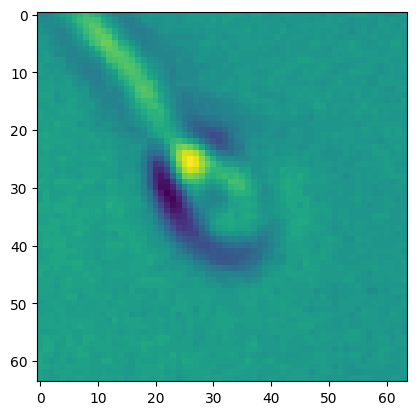

In [8]:
plt.imshow(trainset.imgs[30][0])
print(trainset.img_labels[30])

In [9]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    """ Shows random N samples from the dataset """
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        if isinstance(sample, tuple): # then it is in the form (x, y)
          sample, label = sample

          if isinstance(label, torch.Tensor):
            label = int(label.item())
          if labels:
            label = labels[label]
          axs[0, i].title.set_text(label)
        # print(threeChannelImg(sample).shape)
        axs[0, i].imshow(sample.type(torch.int16).permute(1, 2, 0))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

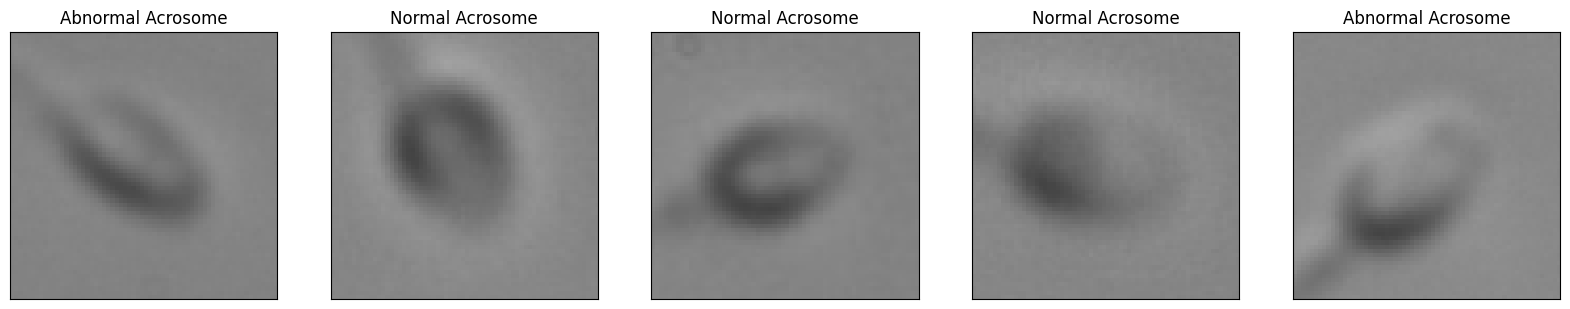

In [10]:
idx_to_labels = {0: "Normal Acrosome", 1: "Abnormal Acrosome"}
show(trainset, labels=idx_to_labels)

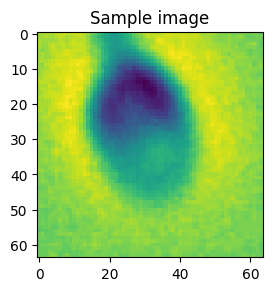

In [11]:
image = trainset.imgs[1][0]
plt.subplot(1, 2, 2)
plt.title("Sample image")
plt.imshow(image)
plt.show()

# **VGG on Acrosome Targets**

x_train.shape:  (1000, 64, 64)
x_dev.shape:  (240, 64, 64)
x_test.shape:  (300, 64, 64)
y_acrosome_train.shape:  (1000,)
----------------------------------------
each image size:  torch.Size([3, 64, 64])
each label size:  torch.Size([])


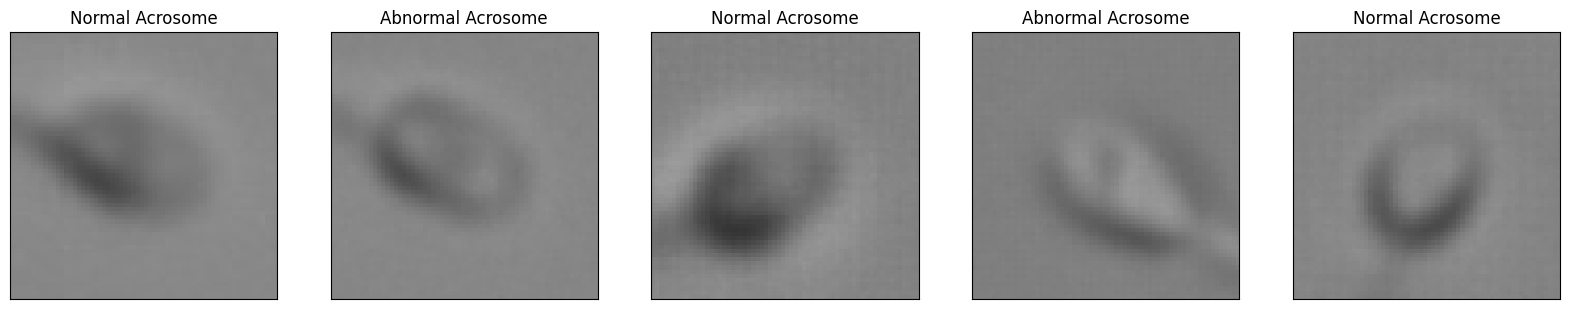

In [21]:
trainset, devset, testset = constructDataset(data_shape=64, target_type='acrosome')
print('--'*20 + '\n' + 'each image size: ', trainset.imgs[0].shape)
print('each label size: ', trainset.img_labels[0].shape)

idx_to_labels = {0: "Normal Acrosome", 1: "Abnormal Acrosome"}
show(trainset, labels=idx_to_labels)

In [22]:
model = torchvision.models.vgg16()
model.classifier[6] = nn.Linear(4096, 2)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
class VGG16BinaryClassification(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.vgg16(pretrained=True)
        self.model.classifier[6] = nn.Linear(4096, 2)

        unfreeze = ['classifier']
        for layer_name, layer in self.model.named_parameters():
            for name in unfreeze:
                if name in layer_name:
                    layer.requires_grad = True
                    break
                else:
                    layer.requires_grad = False

    def forward(self, x):
        return self.model(x)

class VGG19BinaryClassification(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.vgg19(pretrained=True)
        self.model.classifier[6] = nn.Linear(4096, 2)

        unfreeze = ['classifier']
        for layer_name, layer in self.model.named_parameters():
            for name in unfreeze:
                if name in layer_name:
                    layer.requires_grad = True
                    break
                else:
                    layer.requires_grad = False

    def forward(self, x):
        return self.model(x)

In [24]:
def evaluate(dataset, model, device='cpu', **dataloader_args):
    dataloader = DataLoader(dataset, **dataloader_args)
    preds = []
    labels = []
    with torch.no_grad():
        model.eval()
        model.to(device)

        for x_batch, y_batch in tqdm(dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.tolist()

            outs = model(x_batch).detach().cpu()
            predictions = torch.argmax(torch.softmax(outs, 1), 1).tolist()

            # extend the `preds` and `labels` lists with predictions and true labels
            preds.extend(predictions)
            labels.extend(y_batch)

    report = classification_report(labels, preds, digits = 3)
    report_dict = classification_report(labels, preds, output_dict=True)
    print(report)
    return report_dict

def train(model, loss_fn,
          train_loader, val_loader,return_model=False,
          device='cpu', lr_adjuster=None, epochs=10):

    n_train = len(train_loader.dataset)
    n_val = len(val_loader.dataset)

    training_losses = []
    validation_losses = []

    # initialize the model
    optimizer = get_optimizer(model)

    # pass the model to the given device
    model.to(device)

    print("Number of samples")
    print("Training:", n_train)
    print('Validation:', n_val)
    for epoch in range(epochs):
        # define running losses
        epoch_training_running_loss = 0
        epoch_val_running_loss = 0

        if lr_adjuster:
            lr = lr_adjuster(optimizer, epoch)

        bar = tqdm(enumerate(train_loader), total=n_train//train_loader.batch_size)
        # loop through every batch in the training loader
        for batch_idx, (x_batch, y_batch) in bar:
            # pass the batches to given device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # set the gradients to 0 beforehand
            # it can also be written after `optimizer.step()`, just a preference.
            outs = model(x_batch)
            loss = loss_fn(outs, y_batch)
            # calculate the gradients and apply an optimization step
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # we can use `.item()` method to read the loss value
            # since the loss function automatically calculates the loss by averaging the input size,
            # we will multiply it with the batch size to add it
            # then we can average it by the whole dataset size
            # note: it is also possible to average the loss by the number of batches at the end of the epoch (without multiplying with x_batch.size(0))
            # but this approach is more straightforward.
            epoch_training_running_loss += (loss.item() * x_batch.size(0))

        with torch.no_grad():
            model.eval()
            vbar = tqdm(val_loader, total=n_val//val_loader.batch_size)
            for x_batch, y_batch in vbar:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                outs = model(x_batch)
                loss = loss_fn(outs, y_batch)

                epoch_val_running_loss += (loss.item() * x_batch.size(0))
            model.train()

        average_training_loss = epoch_training_running_loss / n_train
        average_validation_loss = epoch_val_running_loss / n_val

        training_losses.append(average_training_loss)
        validation_losses.append(average_validation_loss)

        if lr_adjuster:
            print(f"epoch {epoch+1}/{epochs}, lr={lr} | avg. training loss: {average_training_loss:.3f}, avg. validation loss: {average_validation_loss:.3f}")
        else:
            print(f"epoch {epoch+1}/{epochs} | avg. training loss: {average_training_loss:.3f}, avg. validation loss: {average_validation_loss:.3f}")


    # return the training and validtion losses, also return the model if return_model is True
    if return_model:
        return training_losses, validation_losses, model
    else:
        return training_losses, validation_losses

def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=2e-4, betas=(0.9, 0.999), eps=1e-8)
    return optimizer

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda
Number of samples
Training: 1000
Validation: 240


4it [00:00,  5.31it/s]
1it [00:00,  8.98it/s]


epoch 1/30, lr=3e-05 | avg. training loss: 2.969, avg. validation loss: 0.733


4it [00:00,  5.83it/s]
1it [00:00,  8.97it/s]


epoch 2/30, lr=0.0001 | avg. training loss: 2.326, avg. validation loss: 0.900


4it [00:00,  5.71it/s]
1it [00:00,  8.50it/s]


epoch 3/30, lr=0.0001 | avg. training loss: 1.308, avg. validation loss: 0.615


4it [00:00,  5.84it/s]
1it [00:00,  7.14it/s]


epoch 4/30, lr=0.0001 | avg. training loss: 0.821, avg. validation loss: 0.571


4it [00:00,  5.67it/s]
1it [00:00,  8.07it/s]


epoch 5/30, lr=0.0001 | avg. training loss: 0.758, avg. validation loss: 0.628


4it [00:00,  5.84it/s]
1it [00:00,  8.85it/s]


epoch 6/30, lr=1e-05 | avg. training loss: 0.695, avg. validation loss: 0.614


4it [00:00,  5.62it/s]
1it [00:00,  8.74it/s]


epoch 7/30, lr=1e-05 | avg. training loss: 0.667, avg. validation loss: 0.601


4it [00:00,  5.76it/s]
1it [00:00,  8.48it/s]


epoch 8/30, lr=1e-05 | avg. training loss: 0.650, avg. validation loss: 0.591


4it [00:00,  5.74it/s]
1it [00:00,  8.75it/s]


epoch 9/30, lr=6e-06 | avg. training loss: 0.642, avg. validation loss: 0.587


4it [00:00,  5.52it/s]
1it [00:00,  8.61it/s]


epoch 10/30, lr=6e-06 | avg. training loss: 0.658, avg. validation loss: 0.586


4it [00:00,  5.78it/s]
1it [00:00,  8.67it/s]


epoch 11/30, lr=6e-06 | avg. training loss: 0.669, avg. validation loss: 0.585


4it [00:00,  5.93it/s]
1it [00:00,  9.02it/s]


epoch 12/30, lr=6e-06 | avg. training loss: 0.650, avg. validation loss: 0.586


4it [00:00,  5.83it/s]
1it [00:00,  8.74it/s]


epoch 13/30, lr=6e-06 | avg. training loss: 0.647, avg. validation loss: 0.587


4it [00:00,  5.81it/s]
1it [00:00,  8.86it/s]


epoch 14/30, lr=6e-06 | avg. training loss: 0.639, avg. validation loss: 0.589


4it [00:00,  5.86it/s]
1it [00:00,  8.69it/s]


epoch 15/30, lr=6e-06 | avg. training loss: 0.635, avg. validation loss: 0.591


4it [00:00,  5.81it/s]
1it [00:00,  8.92it/s]


epoch 16/30, lr=6e-06 | avg. training loss: 0.617, avg. validation loss: 0.592


4it [00:00,  5.80it/s]
1it [00:00,  8.89it/s]


epoch 17/30, lr=6e-06 | avg. training loss: 0.633, avg. validation loss: 0.592


4it [00:00,  5.80it/s]
1it [00:00,  8.81it/s]


epoch 18/30, lr=6e-06 | avg. training loss: 0.648, avg. validation loss: 0.592


4it [00:00,  5.73it/s]
1it [00:00,  8.69it/s]


epoch 19/30, lr=6e-06 | avg. training loss: 0.646, avg. validation loss: 0.593


4it [00:00,  5.65it/s]
1it [00:00,  8.92it/s]


epoch 20/30, lr=6e-06 | avg. training loss: 0.636, avg. validation loss: 0.592


4it [00:00,  5.82it/s]
1it [00:00,  8.69it/s]


epoch 21/30, lr=6e-06 | avg. training loss: 0.613, avg. validation loss: 0.591


4it [00:00,  5.69it/s]
1it [00:00,  8.97it/s]


epoch 22/30, lr=6e-06 | avg. training loss: 0.608, avg. validation loss: 0.590


4it [00:00,  5.77it/s]
1it [00:00,  8.18it/s]


epoch 23/30, lr=6e-06 | avg. training loss: 0.597, avg. validation loss: 0.590


4it [00:00,  5.76it/s]
1it [00:00,  8.68it/s]


epoch 24/30, lr=6e-06 | avg. training loss: 0.638, avg. validation loss: 0.590


4it [00:00,  5.66it/s]
1it [00:00,  8.57it/s]


epoch 25/30, lr=6e-06 | avg. training loss: 0.622, avg. validation loss: 0.592


4it [00:00,  5.66it/s]
1it [00:00,  8.58it/s]


epoch 26/30, lr=6e-06 | avg. training loss: 0.630, avg. validation loss: 0.592


4it [00:00,  5.66it/s]
1it [00:00,  8.62it/s]


epoch 27/30, lr=6e-06 | avg. training loss: 0.629, avg. validation loss: 0.593


4it [00:00,  5.67it/s]
1it [00:00,  8.79it/s]


epoch 28/30, lr=6e-06 | avg. training loss: 0.626, avg. validation loss: 0.594


4it [00:00,  5.72it/s]
1it [00:00,  8.59it/s]


epoch 29/30, lr=6e-06 | avg. training loss: 0.624, avg. validation loss: 0.593


4it [00:00,  5.74it/s]
1it [00:00,  8.84it/s]


epoch 30/30, lr=6e-06 | avg. training loss: 0.619, avg. validation loss: 0.593


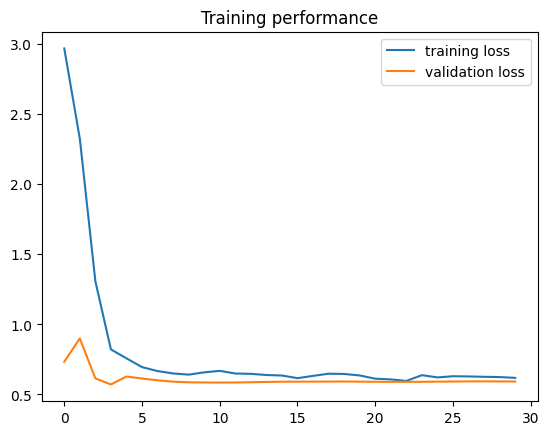

In [25]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 3e-5

    elif epoch < 5:
        lr = 1e-4

    elif epoch < 8:
        lr = 1e-5
    else:
        lr = 6e-6

    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr

train_loader = DataLoader(trainset, batch_size=256, shuffle=True)
val_loader = DataLoader(devset, batch_size=256, shuffle=False)
test_loader = DataLoader(testset, batch_size=256, shuffle=False)

model = VGG16BinaryClassification()
loss_fn = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
training_loss, validation_loss, model = train(model, loss_fn, train_loader, val_loader,
                                              lr_adjuster=adjust_lr, return_model=True, device=device, epochs=30)

plt.title('Training performance')
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()
plt.show()

In [26]:
print("Training report")
training_report = evaluate(trainset, model, device=device, batch_size=256)
print("Validation report")
validation_report = evaluate(devset, model, device=device, batch_size=256)
print("Test report")
test_report = evaluate(testset, model, device=device, batch_size=256)

Training report


100%|██████████| 4/4 [00:00<00:00,  8.41it/s]


              precision    recall  f1-score   support

           0      0.711     0.980     0.824       699
           1      0.611     0.073     0.131       301

    accuracy                          0.707      1000
   macro avg      0.661     0.527     0.477      1000
weighted avg      0.681     0.707     0.615      1000

Validation report


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


              precision    recall  f1-score   support

           0      0.725     0.971     0.830       174
           1      0.286     0.030     0.055        66

    accuracy                          0.713       240
   macro avg      0.506     0.501     0.443       240
weighted avg      0.604     0.713     0.617       240

Test report


100%|██████████| 2/2 [00:00<00:00, 13.54it/s]

              precision    recall  f1-score   support

           0      0.714     0.972     0.823       213
           1      0.400     0.046     0.082        87

    accuracy                          0.703       300
   macro avg      0.557     0.509     0.453       300
weighted avg      0.623     0.703     0.608       300



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


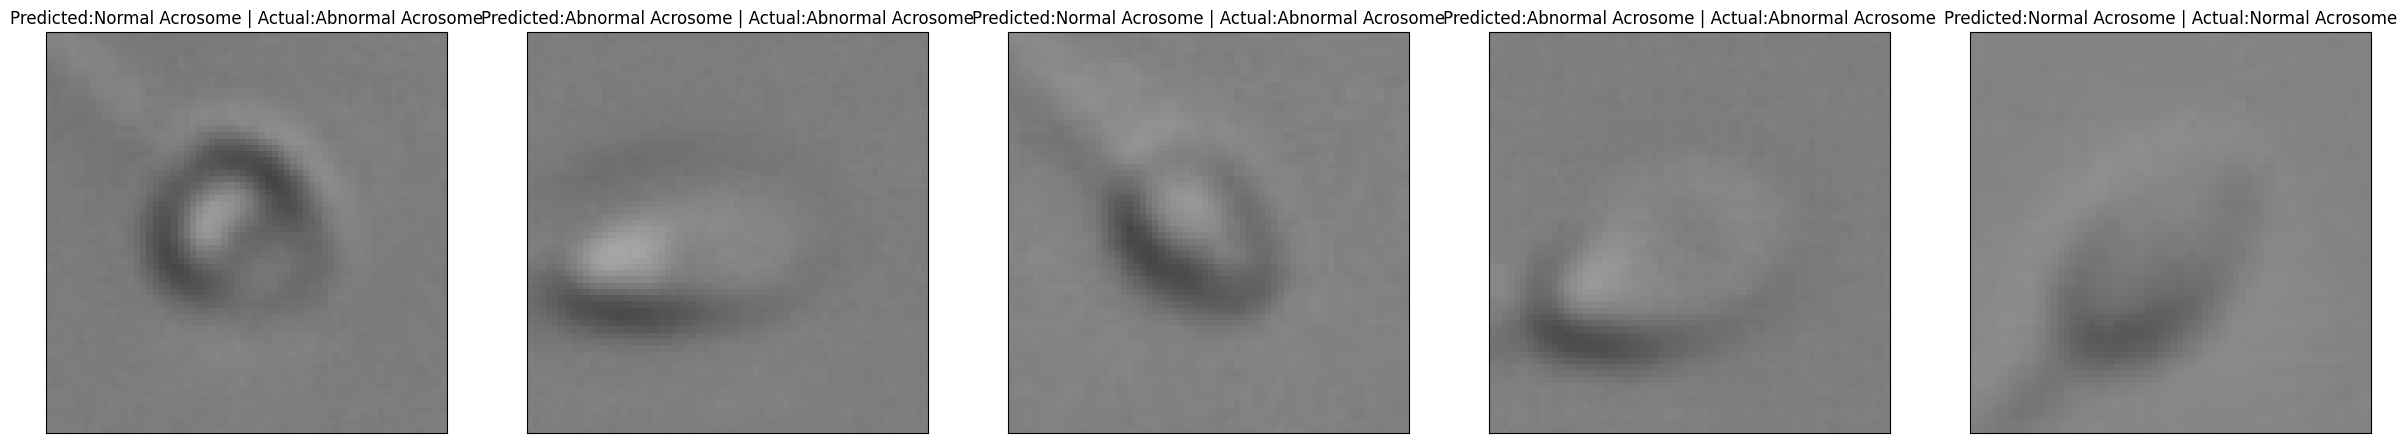

In [27]:
idx_to_labels = {0: "Normal Acrosome", 1: "Abnormal Acrosome"}
N=5
random_indices = np.random.randint(0, len(testset)-1, N)
random_samples = [testset[i] for i in random_indices]

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(30,30))

for i in range(N):
    sample = random_samples[i]
    image, label = sample
    # label = int(label
    category = idx_to_labels[label.item()]

    input_image = image.unsqueeze(0).to(device)
    model_output = model(input_image)
    prediction = torch.argmax(torch.softmax(model_output, -1)).item()
    predicted_category = idx_to_labels[prediction]

    axs[i].imshow(image.type(torch.int32).permute(1, 2, 0))
    axs[i].set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    axs[i].set_title(f'Predicted:{predicted_category} | Actual:{category}')
plt.show()

In [28]:
# saving the model
PATH = '/content/drive/MyDrive/AI Projects/Meta-learning vision project/Models/VGG16/model.pt'
torch.save(model, PATH)

In [29]:
# load model
PATH = '/content/drive/MyDrive/AI Projects/Meta-learning vision project/Models/VGG16/model.pt'
model = torch.load(PATH)
model.eval()

VGG16BinaryClassification(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

# **MAML on Head Target**

x_train.shape:  (1000, 64, 64)
x_dev.shape:  (240, 64, 64)
x_test.shape:  (300, 64, 64)
y_acrosome_train.shape:  (1000,)
----------------------------------------
each image size:  torch.Size([3, 64, 64])
each label size:  torch.Size([])


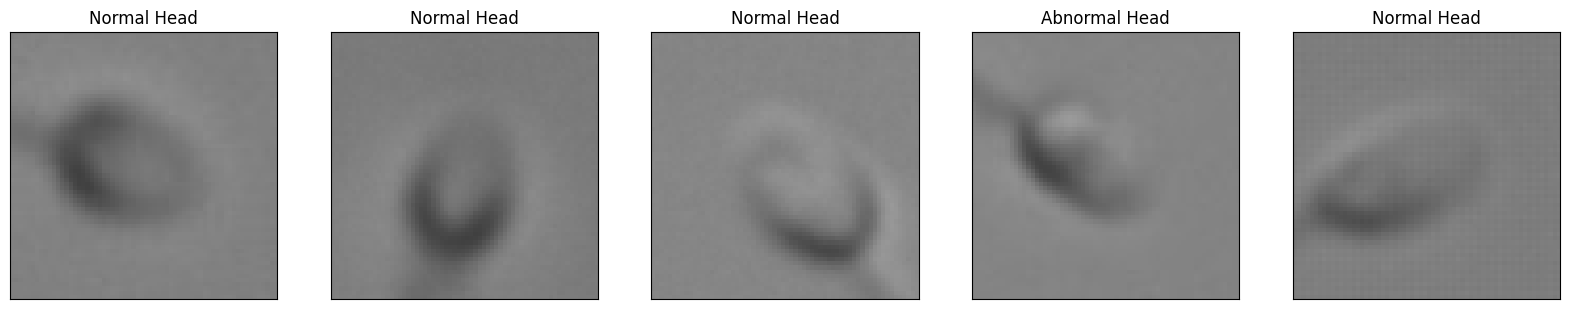

In [57]:
trainset, devset, testset = constructDataset(data_shape=64, target_type='head')
print('--'*20 + '\n' + 'each image size: ', trainset.imgs[0].shape)
print('each label size: ', trainset.img_labels[0].shape)

idx_to_labels = {0: "Normal Head", 1: "Abnormal Head"}
show(trainset, labels=idx_to_labels)

In [43]:
class NShotTaskSampler(Sampler):
    def __init__(self,
                 dataset: torch.utils.data.Dataset,
                 episodes_per_epoch: int = None,
                 n: int = None,
                 k: int = None,
                 q: int = None,
                 num_tasks: int = 1):

        """PyTorch Sampler subclass that generates batches of n-shot, k-way,
        q-query tasks.

        Each n-shot task contains a "support set" of `k` sets of `n` samples and
        a "query set" of `k` sets of `q` samples. The support set and the query set
        are all grouped into one Tensor such that the first n * k samples are from
        the support set while the remaining q * k samples are from the query set.

        The support and query sets are sampled such that they are disjoint
        i.e. do not contain overlapping samples.

        # Arguments
            dataset: Instance of torch.utils.data.Dataset from which to draw samples
            episodes_per_epoch: Arbitrary number of batches of n-shot tasks to
                                generate in one epoch
            n_shot: int. Number of samples for each class in the n-shot
                            classification tasks.
            k_way: int. Number of classes in the n-shot classification tasks.
            q_queries: int. Number query samples for each class in the n-shot
                            classification tasks.
            num_tasks: Number of n-shot tasks to group into a single batch
        """
        super(NShotTaskSampler, self).__init__(dataset)
        self.episodes_per_epoch = episodes_per_epoch
        self.dataset = dataset
        if num_tasks < 1:
            raise ValueError('num_tasks must be > 1.')

        self.num_tasks = num_tasks
        # TODO: Raise errors if initialise badly
        self.k = k
        self.n = n
        self.q = q

    def __len__(self):
        return self.episodes_per_epoch

    def __iter__(self):
        for _ in range(self.episodes_per_epoch):
            batch = []

            for task in range(self.num_tasks):
                # Get random classes

                episode_classes = np.unique(self.dataset.img_labels, return_counts=False)

                for k in episode_classes:
                    support_ids = np.random.choice(np.where(self.dataset.img_labels == k)[0], size=self.n)
                    # print(support_ids)

                    for x in support_ids:
                        batch.append(x)

                for k in episode_classes:
                    query=np.setdiff1d(np.where(self.dataset.img_labels == k)[0], support_ids)
                    query = query[np.random.choice(query.shape[0], self.q, replace=False)]

                    for x in query:
                        batch.append(x)

            yield np.stack(batch)

In [44]:
class VGG16BinaryClassification(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.vgg16(pretrained=True)
        self.model.classifier[6] = nn.Linear(4096, 2)

        # unfreeze = ['classifier']
        # for layer_name, layer in self.model.named_parameters():
        #     for name in unfreeze:
        #         if name in layer_name:
        #             layer.requires_grad = True
        #             break
        #         else:
        #             layer.requires_grad = False

    def forward(self, x):
        return self.model(x)


class VGG19BinaryClassification(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.vgg19(pretrained=True)
        self.model.classifier[6] = nn.Linear(4096, 2)

        # unfreeze = ['classifier']
        # for layer_name, layer in self.model.named_parameters():
        #     for name in unfreeze:
        #         if name in layer_name:
        #             layer.requires_grad = True
        #             break
        #         else:
        #             layer.requires_grad = False

    def forward(self, x):
        return self.model(x)

class VGG11BinaryClassification(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.vgg11(pretrained=True)
        self.model.classifier[6] = nn.Linear(4096, 2)

        # unfreeze = ['classifier']
        # for layer_name, layer in self.model.named_parameters():
        #     for name in unfreeze:
        #         if name in layer_name:
        #             layer.requires_grad = True
        #             break
        #         else:
        #             layer.requires_grad = False

    def forward(self, x):
        return self.model(x)

In [46]:
class ConvNetBinaryClassification(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.convnext_tiny(pretrained=True)
        self.model.classifier[-1] = nn.Linear(768, 2)

        # unfreeze = ['classifier']
        # for layer_name, layer in self.model.named_parameters():
        #     for name in unfreeze:
        #         if name in layer_name:
        #             layer.requires_grad = True
        #             break
        #         else:
        #             layer.requires_grad = False

    def forward(self, x):
        return self.model(x)

In [47]:
model = l2l.vision.models.CNN4(output_size=2, hidden_size=128, channels=3, embedding_size=2048)
model

CNN4(
  (features): CNN4Backbone(
    (0): ConvBlock(
      (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (normalize): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvBlock(
      (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (normalize): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvBlock(
      (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (normalize): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1

In [48]:
from torch.nn.modules.conv import Conv2d
conv1 = Conv2d(3, 128, kernel_size=(3,3), stride=(1,1), padding=(0,0))

# conv1(x_test_tensor).shape

In [49]:
class CNN4PLUS(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        # self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn1 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act4 = nn.ReLU()
        self.conv5 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act5 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn2 = nn.BatchNorm2d(128)

        self.conv6 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act6 = nn.ReLU()
        self.conv7 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act7 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn3 = nn.BatchNorm2d(128)


        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(32768, 256) # 131072 6272
        self.actf = nn.ReLU()
        # self.drop3 = nn.Dropout(0.5)

        #self.fc4 = nn.Linear(256, 64)

        self.fc5 = nn.Linear(256, 2)
        self.actf2 = nn.Sigmoid()

    def forward(self, x):
        # input 1x128x128, output 32x32x32
        x = self.act1(self.conv1(x))
        # x = self.drop1(x)
        # x = self.pool(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        # x = self.pool(x)

        x = self.act3(self.conv3(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.act4(self.conv4(x))
        x = self.act5(self.conv5(x))
        # x = self.pool2(x)
        x = self.bn2(x)
        x = self.act6(self.conv6(x))
        x = self.act7(self.conv7(x))
        # x = self.pool3(x)
        x = self.bn3(x)
        # input 32x32x32, output 32x16x16
        #x = self.pool3(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.actf(self.fc3(x))
        # x = self.drop3(x)
        # input 512, output 10
        #x = self.fc4(x)

        x = self.fc5(x)
        # x = self.act5(x)
        return x

**On MHSMA dataset**

In [51]:
MAML_path = "/content/drive/MyDrive/AI Projects/Meta-learning vision project/MAML.pt"
# MAML_path = "/content/drive/MyDrive/AI Projects/mhsma-dataset/MAML.pt"

def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

def fast_adapt(batch, learner, loss, adaptation_steps, shots, ways, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(shots*ways) * 2] = True
    #print(adaptation_indices)
    evaluation_indices = torch.from_numpy(~adaptation_indices)
    adaptation_indices = torch.from_numpy(adaptation_indices)
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

    # Adapt the model
    for step in range(adaptation_steps):
        adaptation_data = adaptation_data.to(torch.float)
        train_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(train_error)

    # Evaluate the adapted model
    predictions = learner(evaluation_data.to(torch.float))
    valid_error = loss(predictions, evaluation_labels)
    valid_accuracy = accuracy(predictions, evaluation_labels)
    return valid_error, valid_accuracy


def main(
          ways=2,
          shots=10,
          meta_lr=0.0001,#0.003
          fast_lr=0.003,#0.5
          meta_batch_size=20,#32
          adaptation_steps=1,
          num_iterations=100,#60000
          cuda=True,
          seed=42, ):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    device = torch.device('cpu')

    if cuda:
        torch.cuda.manual_seed(seed)
        device = torch.device('cuda')


    epoch_len = meta_batch_size
    train_taskloader = DataLoader(trainset,
                                  batch_sampler=NShotTaskSampler(trainset, epoch_len, n=2*shots,
                                                                  k=ways, q=0,
                                                                  num_tasks=1),
                                  num_workers=1
    )
    dev_taskloader = DataLoader(devset,
                                batch_sampler=NShotTaskSampler(devset, epoch_len, n=0,
                                                                k=ways, q=2*shots,
                                                                num_tasks=1),
                                num_workers=1
    )
    test_taskloader = DataLoader(testset,
                                batch_sampler=NShotTaskSampler(testset, epoch_len, n=0,
                                                                k=ways, q=2*shots,
                                                                num_tasks=1),
                                num_workers=1
    )

    # Create model
    model = l2l.vision.models.CNN4(output_size=ways, hidden_size=128, channels=3, embedding_size=2048) #l2l.vision.models.OmniglotFC(128 * 128, ways)#CIFAR10Model()
    # model = l2l.vision.models.WRN28(output_size=ways, hidden_size=128)
    # model = CIFAR10Model()
    # model = ConvNetBinaryClassification()
    # model  = VGG16BinaryClassification()

    model.to(device)
    maml = l2l.algorithms.MAML(model, lr=fast_lr, first_order=False)
    opt = optim.Adam(maml.parameters(), meta_lr)
    loss = nn.CrossEntropyLoss(reduction='mean')

    best_valid_loss = float('inf')
    for iteration in range(num_iterations):
        opt.zero_grad()
        meta_train_error = 0.0
        meta_train_accuracy = 0.0
        meta_valid_error = 0.0
        meta_valid_accuracy = 0.0
        for train_batch, val_batch in zip(train_taskloader, dev_taskloader): # epoch_len     #range(meta_batch_size):
            # Compute meta-training loss
            learner = maml.clone()

            evaluation_error, evaluation_accuracy = fast_adapt(train_batch,
                                                                learner,
                                                                loss,
                                                                adaptation_steps,
                                                                shots,
                                                                ways,
                                                                device)

            evaluation_error.backward()
            meta_train_error += evaluation_error.item()
            meta_train_accuracy += evaluation_accuracy.item()

            # Compute meta-validation loss
            learner = maml.clone()

            evaluation_error, evaluation_accuracy = fast_adapt(val_batch,
                                                               learner,
                                                               loss,
                                                               adaptation_steps,
                                                               shots,
                                                               ways,
                                                               device)
            meta_valid_error += evaluation_error.item()
            meta_valid_accuracy += evaluation_accuracy.item()

            if meta_valid_error < best_valid_loss:
              best_valid_loss = meta_valid_error
              torch.save(learner, MAML_path)

        # Print some metrics
        if (iteration+1) % 5 == 0:
          print('\n')
          print('Iteration', iteration)
          print('Meta Train Error', meta_train_error / meta_batch_size)
          print('Meta Train Accuracy', meta_train_accuracy / meta_batch_size)
          print('Meta Valid Error', meta_valid_error / meta_batch_size)
          print('Meta Valid Accuracy', meta_valid_accuracy / meta_batch_size)

        # Average the accumulated gradients and optimize
        for p in maml.parameters():
            p.grad.data.mul_(1.0 / meta_batch_size)
        opt.step()

    meta_test_error = 0.0
    meta_test_accuracy = 0.0
    for test_batch in test_taskloader:
        # Compute meta-testing loss
        learner = maml.clone()

        evaluation_error, evaluation_accuracy = fast_adapt(test_batch,
                                                           learner,
                                                           loss,
                                                           adaptation_steps,
                                                           shots,
                                                           ways,
                                                           device)
        meta_test_error += evaluation_error.item()
        meta_test_accuracy += evaluation_accuracy.item()
    print('Meta Test Error', meta_test_error / meta_batch_size)
    print('Meta Test Accuracy', meta_test_accuracy / meta_batch_size)


if __name__ == '__main__':
    main()



Iteration 4
Meta Train Error 0.7484264582395553
Meta Train Accuracy 0.48750001192092896
Meta Valid Error 0.7130543291568756
Meta Valid Accuracy 0.5475000143051147


Iteration 9
Meta Train Error 0.7192516893148422
Meta Train Accuracy 0.5350000128149986
Meta Valid Error 0.6932045966386795
Meta Valid Accuracy 0.5500000074505806


Iteration 14
Meta Train Error 0.677611181139946
Meta Train Accuracy 0.5750000163912773
Meta Valid Error 0.7141617506742477
Meta Valid Accuracy 0.560000017285347


Iteration 19
Meta Train Error 0.6353259742259979
Meta Train Accuracy 0.6650000080466271
Meta Valid Error 0.6778860479593277
Meta Valid Accuracy 0.5675000160932541


Iteration 24
Meta Train Error 0.6359257340431214
Meta Train Accuracy 0.6375000104308128
Meta Valid Error 0.6847298264503479
Meta Valid Accuracy 0.5125000104308128


Iteration 29
Meta Train Error 0.6384360253810882
Meta Train Accuracy 0.647500017285347
Meta Valid Error 0.678635784983635
Meta Valid Accuracy 0.5550000131130218


Iteration 34


In [52]:
model = torch.load(MAML_path)
model.eval()

MAML(
  (module): CNN4(
    (features): CNN4Backbone(
      (0): ConvBlock(
        (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (normalize): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvBlock(
        (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (normalize): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): ConvBlock(
        (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (normalize): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        

**Result on trainset**

In [53]:
# print(testset.imgs.shape)
train_pred = model(trainset.imgs.type(torch.cuda.FloatTensor))
train_pred.shape, accuracy(train_pred, trainset.img_labels.to(torch.device('cuda')))

(torch.Size([1000, 2]), tensor(0.7240, device='cuda:0'))

**Result on devtset**

In [54]:
# print(testset.imgs.shape)
dev_pred = model(devset.imgs.type(torch.cuda.FloatTensor))
dev_pred.shape, accuracy(dev_pred, devset.img_labels.to(torch.device('cuda')))

(torch.Size([240, 2]), tensor(0.6208, device='cuda:0'))

**Result on testset**

In [55]:
# print(testset.imgs.shape)
test_pred = model(testset.imgs.type(torch.cuda.FloatTensor))
test_pred.shape, accuracy(test_pred, testset.img_labels.to(torch.device('cuda')))

(torch.Size([300, 2]), tensor(0.6200, device='cuda:0'))